In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Загрузка весов. Запустите, чтобы добавить их

In [ ]:
import urllib.request
prepared_discr_url='https://raw.githubusercontent.com/Shpunka/GAN_Pokemons/main/discriminator.pth'
urllib.request.urlretrieve(prepared_discr_url,"discriminator.pth")
prepared_gen_url='https://raw.githubusercontent.com/Shpunka/GAN_Pokemons/main/generator.pth'
urllib.request.urlretrieve(prepared_gen_url,"generator.pth")

('generator.pth', <http.client.HTTPMessage at 0x785434743eb0>)

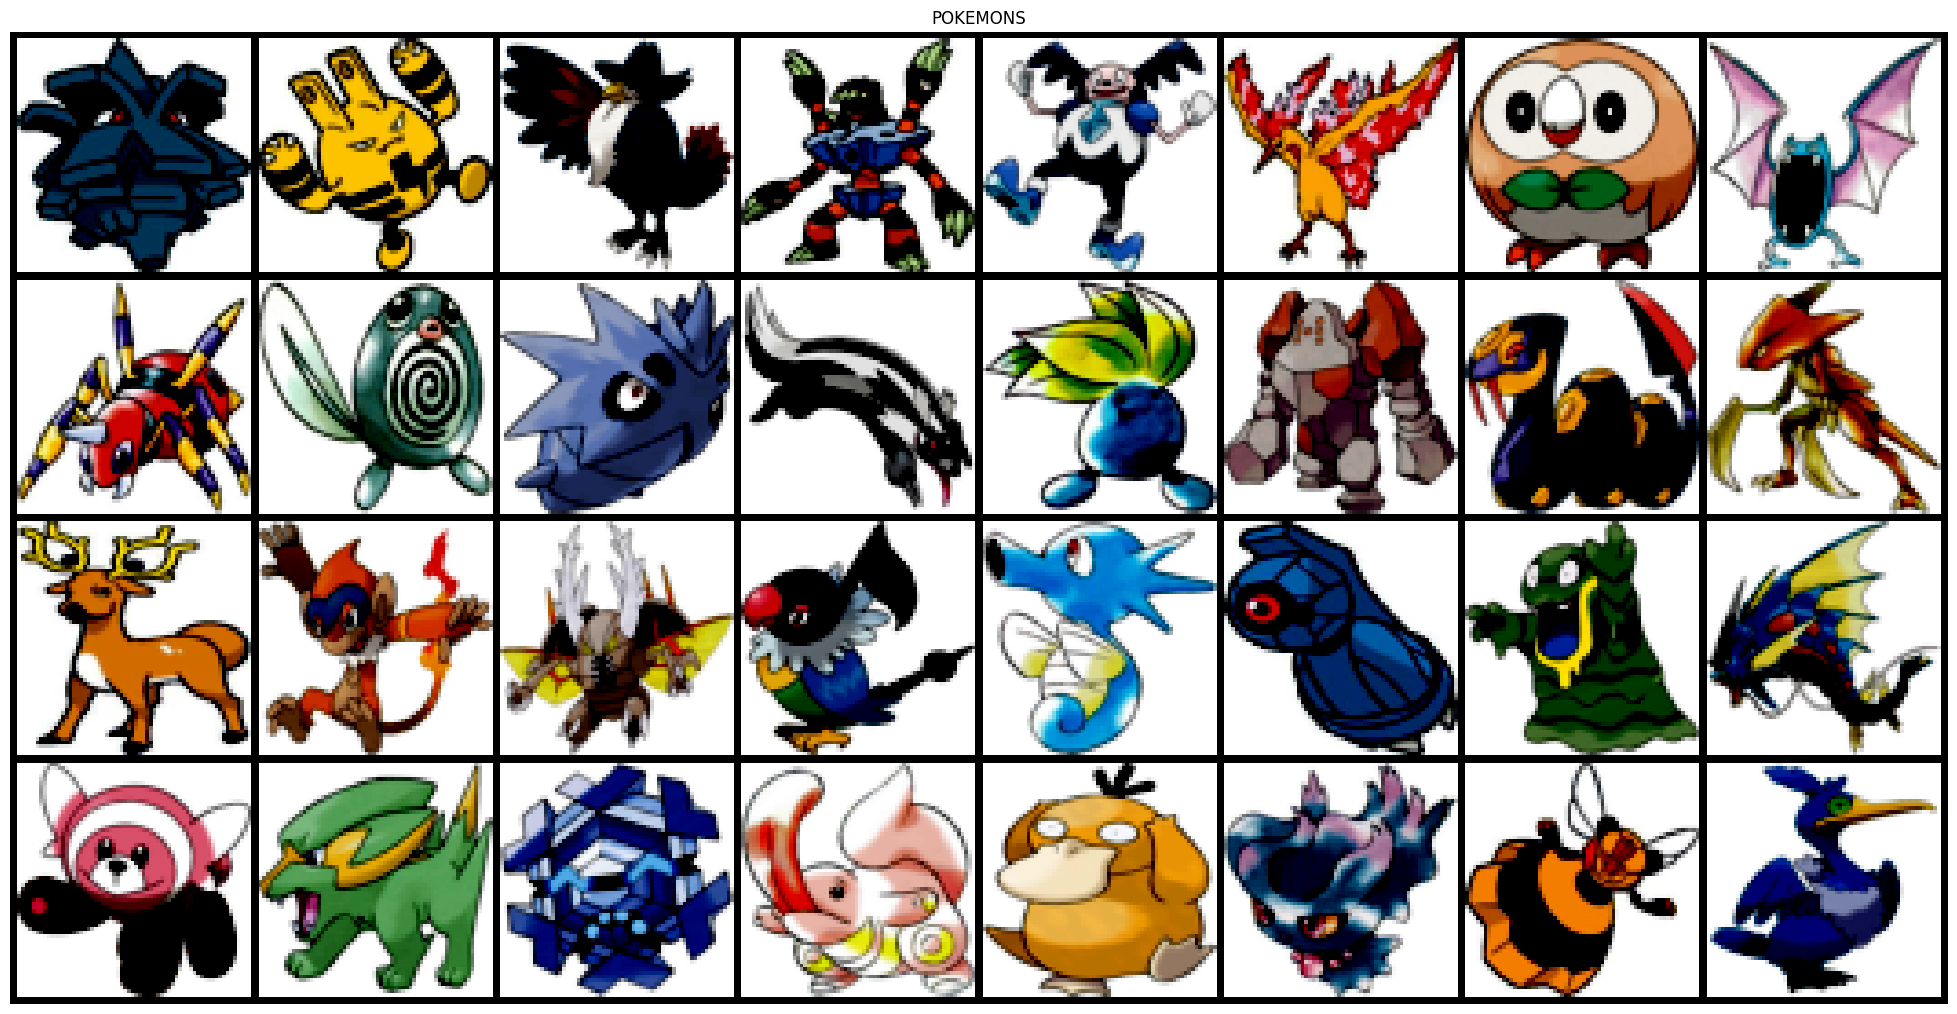

In [ ]:
batch_size = 32
image_size = 64

data_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

pokemon_dataset = ImageFolder(root='/content/drive/MyDrive/images', transform=data_transform)
data_loader = DataLoader(pokemon_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

#Визуализируем
def imshow(img, figsize=(25, 16)):
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.title('POKEMONS')
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

'''

Создаем итератор из загрузчика данных dataiter.
После этого images, _ используется для получения следущего
батча(набора данных) из итератора

'''

dataiter = iter(data_loader)
images, _ = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# **Generator**

In [ ]:
from typing import no_type_check_decorator
nz = 100
ngf = 64
nc = 3

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# **Discriminator**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Создание экземпляров генератора и дискриминатора
generator = Generator(nz, ngf, nc).to(device)
discriminator = Discriminator().to(device)

In [ ]:
#Загрузка весов
generator.load_state_dict(torch.load('/content/generator.pth'))
discriminator.load_state_dict(torch.load('/content/discriminator.pth'))


<All keys matched successfully>

In [ ]:
# Определение критерия и оптимизаторов
learning_rate = 0.0002

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
def train_generator(generator, discriminator, optimizer_G, batch_size, latent_dim, device):
    optimizer_G.zero_grad()
    noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(noise)
    validity = discriminator(fake_images)
    target = torch.ones_like(validity)
    loss = adversarial_loss(validity, target)
    loss.backward()
    optimizer_G.step()
    return loss.item()

def train_discriminator(generator, discriminator, optimizer_D, real_images, batch_size, latent_dim, device):
    optimizer_D.zero_grad()
    real_validity = discriminator(real_images)
    real_target = torch.ones_like(real_validity)
    real_loss = adversarial_loss(real_validity, real_target)

    noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(noise)
    fake_validity = discriminator(fake_images.detach())
    fake_target = torch.zeros_like(fake_validity)
    fake_loss = adversarial_loss(fake_validity, fake_target)

    loss = (real_loss + fake_loss) / 2
    loss.backward()
    optimizer_D.step()
    return loss.item()

In [ ]:
#Обучение модели

num_epochs = 50

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(data_loader):
        real_images = real_images.to(device)

        # Обучение дискриминатора
        d_loss = train_discriminator(generator, discriminator, optimizer_D, real_images, batch_size, 100, device)

        # Обучение генератора каждые 2 шага дискриминатора
        # if i % 2 == 0:
        g_loss = train_generator(generator, discriminator, optimizer_G, batch_size, 100, device)

        # Выводим промежуточные результаты
        if i % 10 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(data_loader)}] [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

    # Сохраняем сгенерированные изображения после каждой эпохи
    with torch.no_grad():
        noise = torch.randn(16, 100, 1, 1, device=device)
        generated_images = generator(noise)
        save_image(generated_images, f"generated_images_epoch_{epoch + 1}.png", normalize=True)

print("Обучение завершено!")

# Сохранение генератора и дискриминатора
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


[Epoch 0/50] [Batch 0/79] [D loss: 0.0569] [G loss: 8.7563]
[Epoch 0/50] [Batch 10/79] [D loss: 0.1275] [G loss: 4.4648]
[Epoch 0/50] [Batch 20/79] [D loss: 0.1344] [G loss: 5.5217]
[Epoch 0/50] [Batch 30/79] [D loss: 0.1325] [G loss: 4.8539]
[Epoch 0/50] [Batch 40/79] [D loss: 0.1344] [G loss: 3.7508]
[Epoch 0/50] [Batch 50/79] [D loss: 0.3602] [G loss: 1.6454]
[Epoch 0/50] [Batch 60/79] [D loss: 0.1064] [G loss: 4.1645]
[Epoch 0/50] [Batch 70/79] [D loss: 0.1219] [G loss: 3.9559]
[Epoch 1/50] [Batch 0/79] [D loss: 0.3141] [G loss: 8.2423]
[Epoch 1/50] [Batch 10/79] [D loss: 0.2260] [G loss: 6.0755]
[Epoch 1/50] [Batch 20/79] [D loss: 0.1065] [G loss: 4.2283]
[Epoch 1/50] [Batch 30/79] [D loss: 0.5088] [G loss: 7.8858]
[Epoch 1/50] [Batch 40/79] [D loss: 0.1917] [G loss: 2.4177]
[Epoch 1/50] [Batch 50/79] [D loss: 0.1269] [G loss: 3.6902]
[Epoch 1/50] [Batch 60/79] [D loss: 0.1147] [G loss: 4.4439]
[Epoch 1/50] [Batch 70/79] [D loss: 0.2281] [G loss: 4.5304]
[Epoch 2/50] [Batch 0/79] 

Визуализация сгенерированных покемонов

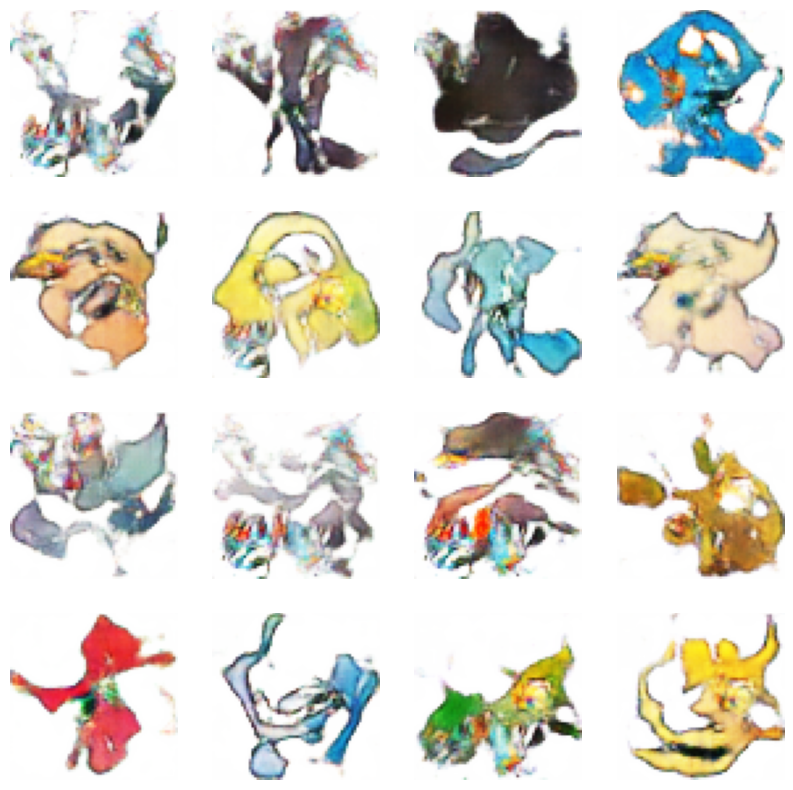

In [ ]:
def show_generated_images(generator, num_images=16, latent_dim=100, device='cuda'):
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim, 1, 1, device=device)
        generated_images = generator(noise).cpu()


    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        img = generated_images[i].numpy().transpose((1, 2, 0))
        plt.imshow(0.5 * img + 0.5)  # Используем нормализацию для корректного отображения
        plt.axis('off')
    plt.show()

# Показать итоговые изображения
show_generated_images(generator, num_images=16, device=device)